In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import vcf

%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from itertools import compress
from pylab import MaxNLocator
import seaborn as sns; sns.set()
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import ast
import itertools
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import fastcluster
from sklearn import cluster, datasets
import scipy.cluster.hierarchy as hier
from sklearn.cluster import KMeans
import time
import sys

import Bio
from Bio.Alphabet import IUPAC
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio import pairwise2
from Bio import SeqIO
from Bio.Graphics import GenomeDiagram
from Bio.SeqUtils import GC

from Bio.Align.Applications import MuscleCommandline
from StringIO import StringIO
from Bio import AlignIO
from Bio.Align import AlignInfo
from Bio.Seq import MutableSeq
import itertools

import networkx as nx
import scipy
from collections import Counter

from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes
import math

#for exporting to Adobe Illustrator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

### Load in Sample Annotation & both DataFrames from In-Host SNP analysis

#### Import Sample Annotation file for all patients that have been filtered by Lineage Call and Fixed SNP Distance

In [3]:
sample_annotation = pd.read_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/sample_annotation_files/Longitudinal_fastq_path_names_and_JankyPipe_tags_filtered_final.csv' , sep = ',').set_index('patient_id')

In [4]:
sample_annotation.head()

,fastq_files,population,run_ID,sample_ID,sample_order,tag,isolate_type
patient_id,,,,,,,
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039337,NaN,1,ERR039337,longitudinal
P000183,/n/data1/hms/dbmi/farhat/fastq_db/walker/ERR03...,WALKER,ERR039338,NaN,2,ERR039338,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMJA00000000,Peru5115,1,Peru5115,longitudinal
1960,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMPC00000000,Peru4668,2,Peru4668,longitudinal
2491,/n/data1/hms/dbmi/farhat/cetr_strains/good_wgs...,CETR,MMZT00000000,Peru4903,1,Peru4903,longitudinal


#### Load in filtered Base Calls (SNPs) from in-host Base Call analysis (pairs of Base Calls that are different *in-host*, have a difference in Alternate Allele Frequency $\ge 70\%$)

**Two** rows per SNP (1 for each isolate)

In [5]:
within_host_Base_Call_variants_all_patients = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/longitudinal_SNP_variants_70_delta_in_alt_AF.pkl')

In [6]:
within_host_Base_Call_variants_all_patients.head()

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change
0,C,Z,761139.0,3140.0,Ref_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [0], u'BC': [0,...",0.0,89.0,ERR369703,CASALI,P251,Rv0667,1333,Antibiotic Resistance,rpoB,None,None
1,C,G,761139.0,1266.0,Alt_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [2], u'BC': [0,...",1.0,36.0,ERR600658,CASALI,P251,Rv0667,1333,Antibiotic Resistance,rpoB,N,H445D
2,T,Z,861378.0,3116.0,Ref_PASS,[],"{u'QP': [0, 0, 0, 100], u'AC': [0], u'BC': [0,...",0.0,90.0,ERR369703,CASALI,P251,Rv0768,467,Non-Essential,aldA,None,None
3,T,G,861378.0,1167.0,Alt_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [2], u'BC': [0,...",1.0,34.0,ERR600658,CASALI,P251,Rv0768,467,Non-Essential,aldA,N,I156S
4,A,Z,1253207.0,2403.0,Ref_PASS,[],"{u'QP': [100, 0, 0, 0], u'AC': [0], u'BC': [66...",0.0,66.0,ERR108130,BRYANT,2020E,Rv1129c,1328,Non-Essential,NaN,None,None


In [7]:
np.shape(within_host_Base_Call_variants_all_patients)

(350, 18)

#### Load in filtered SNPs from within-host Base Call analysis (SNPs that are different *in-host*, have a difference in Alternate Allele Frequencies >= 70%)

**One** row per SNP

In [8]:
SNP_variants_within_patients = pd.read_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/SNPs_between_isolates_delta_70.pkl')

In [9]:
SNP_variants_within_patients.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S
2,BRYANT,2020E,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,1.0,N,I443T
3,BRYANT,2020E,2075138,T,A,Rv1830,298,Non-Essential,NaN,1.0,N,S100T
4,BRYANT,2020E,2694727,A,G,Rv2397c,238,Essential,cysA1,1.0,N,F80L


In [10]:
np.shape(SNP_variants_within_patients)

(175, 12)

### Did the bacteria mutate toward the *Reference* Allele or toward the *Alternate* Allele?

In [11]:
within_host_Base_Call_variants_all_patients_sample_order = pd.merge( within_host_Base_Call_variants_all_patients , sample_annotation.loc[: , ['sample_order' , 'tag']] , how = 'left' , on = 'tag')

In [12]:
within_host_Base_Call_variants_all_patients_sample_order.head()

,ref_base,alt_base,ref_position,quality,SNP_type,PASS_filter,INFO,alt_AF,depth,tag,population,patient_id,gene_id,gene_coord,gene_category,gene_symbol,SNP_ftype,AA_change,sample_order
0,C,Z,761139.0,3140.0,Ref_PASS,[],"{u'QP': [0, 100, 0, 0], u'AC': [0], u'BC': [0,...",0.0,89.0,ERR369703,CASALI,P251,Rv0667,1333,Antibiotic Resistance,rpoB,None,None,1
1,C,G,761139.0,1266.0,Alt_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [2], u'BC': [0,...",1.0,36.0,ERR600658,CASALI,P251,Rv0667,1333,Antibiotic Resistance,rpoB,N,H445D,2
2,T,Z,861378.0,3116.0,Ref_PASS,[],"{u'QP': [0, 0, 0, 100], u'AC': [0], u'BC': [0,...",0.0,90.0,ERR369703,CASALI,P251,Rv0768,467,Non-Essential,aldA,None,None,1
3,T,G,861378.0,1167.0,Alt_PASS,[],"{u'QP': [0, 0, 100, 0], u'AC': [2], u'BC': [0,...",1.0,34.0,ERR600658,CASALI,P251,Rv0768,467,Non-Essential,aldA,N,I156S,2
4,A,Z,1253207.0,2403.0,Ref_PASS,[],"{u'QP': [100, 0, 0, 0], u'AC': [0], u'BC': [66...",0.0,66.0,ERR108130,BRYANT,2020E,Rv1129c,1328,Non-Essential,NaN,None,None,1


In [13]:
np.shape(within_host_Base_Call_variants_all_patients_sample_order)

(350, 19)

In [14]:
population_list = []
patient_list = []
ref_pos_list = []
allele_1_list = [] #allele detected in abundance in 1st isolate
allele_2_list = [] #allele detected in abundance in 2nd isolate
alternate_AF_1 = []
alternate_AF_2 = []
change_in_alternate_AF = []

#for each pair of Base Calls, store (alternate Allele Frequency of isolate_1) and (alternate Allele Frequency of isolate_2 - alternate Allele Frequency of isolate_1)
for Base_Call_A_index , Base_Call_B_index in zip( range(0 , np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0] , 2) , range(1 , np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0] , 2) ):
    
    #find the Base Call index that corresponds to the earlier isolate
    if within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'sample_order'] == 1:
        
        Base_Call_isolate_1 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , :]
        Base_Call_isolate_2 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , :] 

        #if the alternate allele frequency increased, then population is moving toward alternate base
        if Base_Call_isolate_2.alt_AF > Base_Call_isolate_1.alt_AF:
            allele_1 = Base_Call_isolate_1.ref_base #base that was present in the population
            allele_2 = Base_Call_isolate_2.alt_base #base that population is moving toward
            
        #if the alternate allele frequency decreased, then popolation is moving toward reference base
        elif Base_Call_isolate_2.alt_AF < Base_Call_isolate_1.alt_AF:
            allele_1 = Base_Call_isolate_1.alt_base
            allele_2 = Base_Call_isolate_2.ref_base
            
    elif within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , 'sample_order'] == 1:
        
        Base_Call_isolate_1 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , :]
        Base_Call_isolate_2 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , :] 
        
        if Base_Call_isolate_2.alt_AF > Base_Call_isolate_1.alt_AF:
            allele_1 = Base_Call_isolate_1.ref_base
            allele_2 = Base_Call_isolate_2.alt_base
            
        elif Base_Call_isolate_2.alt_AF < Base_Call_isolate_1.alt_AF:
            allele_1 = Base_Call_isolate_1.alt_base
            allele_2 = Base_Call_isolate_2.ref_base
            
    #store the base that population is moving from
    allele_1_list.append(allele_1)
    
    #store the base that population is moving toward
    allele_2_list.append(allele_2)
        
    #store the Alterante Allele Frequency of the first serial isolate
    alternate_AF_1.append(Base_Call_isolate_1.alt_AF)
    
    #stotre the Alternate Allele Frequency of the second serial isolate
    alternate_AF_2.append(Base_Call_isolate_2.alt_AF)
    
    #store the difference of the Alternate Allele Frequencies of both serial isolates
    change_in_alternate_AF.append( Base_Call_isolate_2.alt_AF - Base_Call_isolate_1.alt_AF )
    
    #store study ID, patient ID & reference positions
    population_list.append(Base_Call_isolate_1.population)
    patient_list.append(Base_Call_isolate_1.patient_id)
    ref_pos_list.append(Base_Call_isolate_1.ref_position)
    
#create DataFrame with all Information
change_in_AF_DF = pd.DataFrame()
change_in_AF_DF['population'] = population_list
change_in_AF_DF['patient_id'] = patient_list
change_in_AF_DF['ref_position'] = ref_pos_list
change_in_AF_DF['allele_1'] = allele_1_list
change_in_AF_DF['allele_2'] = allele_2_list
change_in_AF_DF['alt_AF_1'] = alternate_AF_1
change_in_AF_DF['alt_AF_2'] = alternate_AF_2
change_in_AF_DF['altAF2_minus_altAF1'] = change_in_alternate_AF

In [15]:
np.shape(change_in_AF_DF)

(175, 8)

In [16]:
change_in_AF_DF.head()

,population,patient_id,ref_position,allele_1,allele_2,alt_AF_1,alt_AF_2,altAF2_minus_altAF1
0,CASALI,P251,761139.0,C,G,0.0,1.0,1.0
1,CASALI,P251,861378.0,T,G,0.0,1.0,1.0
2,BRYANT,2020E,1253207.0,A,G,0.0,1.0,1.0
3,BRYANT,2020E,2075138.0,T,A,0.0,1.0,1.0
4,BRYANT,2020E,2694727.0,A,G,0.0,1.0,1.0


Merge DataFrame above with DataFrame below to create a master DataFrame that contains all relevant information for the 175 in-host SNPs

In [17]:
SNP_variants_within_patients.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S
2,BRYANT,2020E,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,1.0,N,I443T
3,BRYANT,2020E,2075138,T,A,Rv1830,298,Non-Essential,NaN,1.0,N,S100T
4,BRYANT,2020E,2694727,A,G,Rv2397c,238,Essential,cysA1,1.0,N,F80L


In [18]:
#iterate through 'SNP_variants_within_patients' and store corresponding SNP information from 'change_in_AF_DF' in lists below
allele_1_list = []
allele_2_list = []
alternate_AF_1 = []
alternate_AF_2 = []
change_in_alternate_AF = []

for patient_id , ref_position in zip(list(SNP_variants_within_patients.patient_id) , list(SNP_variants_within_patients.ref_position)):
    
    #create a filter to store the corresponding SNP from the 'change_in_AF_DF'
    SNP_filter = [(patient_id_i == patient_id) and (ref_position_i == ref_position) for patient_id_i , ref_position_i in zip(list(change_in_AF_DF.patient_id) , list(change_in_AF_DF.ref_position))]
    first_second_allele_info_for_SNP = change_in_AF_DF[SNP_filter]
    
    #store information for this SNP in lists
    allele_1_list.append(change_in_AF_DF[SNP_filter].allele_1.values[0])
    allele_2_list.append(change_in_AF_DF[SNP_filter].allele_2.values[0])
    alternate_AF_1.append(change_in_AF_DF[SNP_filter].alt_AF_1.values[0])
    alternate_AF_2.append(change_in_AF_DF[SNP_filter].alt_AF_2.values[0])
    change_in_alternate_AF.append(change_in_AF_DF[SNP_filter].altAF2_minus_altAF1.values[0])
    
#store lists as columns in master DF
SNP_variants_within_patients['allele_1'] = allele_1_list
SNP_variants_within_patients['allele_2'] = allele_2_list
SNP_variants_within_patients['alt_AF_1'] = alternate_AF_1
SNP_variants_within_patients['alt_AF_2'] = alternate_AF_2
SNP_variants_within_patients['altAF2_minus_altAF1'] = change_in_alternate_AF

In [19]:
SNP_variants_within_patients.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change,allele_1,allele_2,alt_AF_1,alt_AF_2,altAF2_minus_altAF1
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D,C,G,0.0,1.0,1.0
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S,T,G,0.0,1.0,1.0
2,BRYANT,2020E,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,1.0,N,I443T,A,G,0.0,1.0,1.0
3,BRYANT,2020E,2075138,T,A,Rv1830,298,Non-Essential,NaN,1.0,N,S100T,T,A,0.0,1.0,1.0
4,BRYANT,2020E,2694727,A,G,Rv2397c,238,Essential,cysA1,1.0,N,F80L,A,G,0.0,1.0,1.0


Store newly annotated DF for downstream analysis

In [20]:
SNP_variants_within_patients.to_pickle('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/pickled_files/variant_calling/longitudinal_SNPs/SNPs_between_isolates_delta_70_intergenic_annotated_with_allele1_allele2_info.pkl')
SNP_variants_within_patients.to_csv('/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/CSV_files/variant_calling/longitudinal_SNPs/SNPs_between_isolates_delta_70_intergenic_annotated_with_allele1_allele2_info.csv')

### Reference Allele -> Alternate Allele

Alternate Allele Frequency increasing: **Alternate allele rising** in frequency

In [21]:
sum( SNP_variants_within_patients.altAF2_minus_altAF1 > 0.0 )

142

Reference Allele is the first base: **Reference allele falling** in frequency

In [22]:
sum( SNP_variants_within_patients.ref_allele == SNP_variants_within_patients.allele_1 )

142

In [23]:
SNP_variants_within_patients[SNP_variants_within_patients.altAF2_minus_altAF1 > 0.0].head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change,allele_1,allele_2,alt_AF_1,alt_AF_2,altAF2_minus_altAF1
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D,C,G,0.0,1.0,1.0
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S,T,G,0.0,1.0,1.0
2,BRYANT,2020E,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,1.0,N,I443T,A,G,0.0,1.0,1.0
3,BRYANT,2020E,2075138,T,A,Rv1830,298,Non-Essential,NaN,1.0,N,S100T,T,A,0.0,1.0,1.0
4,BRYANT,2020E,2694727,A,G,Rv2397c,238,Essential,cysA1,1.0,N,F80L,A,G,0.0,1.0,1.0


### Alternate Allele -> Reference Allele

Reference Allele Frequency increasing: **Reference allele rising** in frequency

In [24]:
sum( SNP_variants_within_patients.altAF2_minus_altAF1 < 0.0 )

33

Alternate Allele is the first base: **Alternate allele falling** in frequency

In [25]:
sum( SNP_variants_within_patients.ref_allele == SNP_variants_within_patients.allele_2 )

33

In [26]:
SNP_variants_within_patients[SNP_variants_within_patients.altAF2_minus_altAF1 < 0.0].head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change,allele_1,allele_2,alt_AF_1,alt_AF_2,altAF2_minus_altAF1
16,CETR,2918,866109,C,T,Rv0773c,1281,Antigen,ggtA,0.86,S,L427L,T,C,0.86,0.00,-0.86
20,TRAUNER,P09,1013542,C,G,Rv0908,1812,Non-Essential,ctpE,1.00,S,S604S,G,C,1.00,0.00,-1.00
28,WALKER,P000155,2395250,A,G,Rv2134c_Rv2135c,None,None,None,0.96,I,None,G,A,0.96,0.00,-0.96
33,WALKER,P000156,3270363,C,A,Rv2935,2627,Non-Essential,ppsE,0.98,N,A876E,A,C,0.98,0.00,-0.98
35,WALKER,P000095,2123169,T,G,Rv1872c_Rv1873,None,None,None,0.94,I,None,G,T,1.00,0.06,-0.94


### Spectrum of Mutations

In [27]:
first_base_list = []
second_base_list = []
beginning_alternate_AF = []
ending_alternate_AF = []
change_in_alternate_AF = []
Gene_Category = []
Gene_IDs = []

#for each pair of Base Calls, store (alternate Allele Frequency of isolate_1) and (alternate Allele Frequency of isolate_2 - alternate Allele Frequency of isolate_1)
for Base_Call_A_index , Base_Call_B_index in zip( range(0 , np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0] , 2) , range(1 , np.shape(within_host_Base_Call_variants_all_patients_sample_order)[0] , 2) ):
    
    #find the Base Call index that corresponds to the earlier isolate
    if within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , 'sample_order'] == 1:
        
        Base_Call_isolate_1 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , :]
        Base_Call_isolate_2 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , :] 

        #if the alternate allele frequency increased, then population is moving toward alternate base
        if Base_Call_isolate_2.alt_AF > Base_Call_isolate_1.alt_AF:
            first_base = Base_Call_isolate_1.ref_base #base that was present in the population
            second_base = Base_Call_isolate_2.alt_base #base that population is moving toward
            
        #if the alternate allele frequency decreased, then popolation is moving toward reference base
        elif Base_Call_isolate_2.alt_AF < Base_Call_isolate_1.alt_AF:
            first_base = Base_Call_isolate_1.alt_base
            second_base = Base_Call_isolate_2.ref_base
            
    elif within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , 'sample_order'] == 1:
        
        Base_Call_isolate_1 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_B_index , :]
        Base_Call_isolate_2 = within_host_Base_Call_variants_all_patients_sample_order.loc[Base_Call_A_index , :] 
        
        if Base_Call_isolate_2.alt_AF > Base_Call_isolate_1.alt_AF:
            first_base = Base_Call_isolate_1.ref_base
            second_base = Base_Call_isolate_2.alt_base
            
        elif Base_Call_isolate_2.alt_AF < Base_Call_isolate_1.alt_AF:
            first_base = Base_Call_isolate_1.alt_base
            second_base = Base_Call_isolate_2.ref_base
            
    #store the base that population is moving from
    first_base_list.append(first_base)
    
    #store the base that population is moving toward
    second_base_list.append(second_base)
        
    #store the Alterante Allele Frequency of the first serial isolate
    beginning_alternate_AF.append(Base_Call_isolate_1.alt_AF)
    
    #stotre the Alternate Allele Frequency of the second serial isolate
    ending_alternate_AF.append(Base_Call_isolate_2.alt_AF)
    
    #store the difference of the Alternate Allele Frequencies of both serial isolates
    change_in_alternate_AF.append( abs(Base_Call_isolate_2.alt_AF - Base_Call_isolate_1.alt_AF) ) 
    
    #store Gene Category & gene_id of the gene that Reference Position is located on
    Gene_Category.append(Base_Call_isolate_1.gene_category)
    Gene_IDs.append(Base_Call_isolate_1.gene_id)
    
#create DataFrame with all Information
change_in_AF_DF = pd.DataFrame()
change_in_AF_DF['first_base'] = first_base_list
change_in_AF_DF['second_base'] = second_base_list
change_in_AF_DF['beginning_alt_AF'] = beginning_alternate_AF
change_in_AF_DF['ending_alt_AF'] = ending_alternate_AF
change_in_AF_DF['change_alt_AF'] = change_in_alternate_AF
change_in_AF_DF['Gene_Category'] = Gene_Category
change_in_AF_DF['gene_id'] = Gene_IDs

In [28]:
change_in_AF_DF.head()

,first_base,second_base,beginning_alt_AF,ending_alt_AF,change_alt_AF,Gene_Category,gene_id
0,C,G,0.0,1.0,1.0,Antibiotic Resistance,Rv0667
1,T,G,0.0,1.0,1.0,Non-Essential,Rv0768
2,A,G,0.0,1.0,1.0,Non-Essential,Rv1129c
3,T,A,0.0,1.0,1.0,Non-Essential,Rv1830
4,A,G,0.0,1.0,1.0,Essential,Rv2397c


### Organize Mutations by Type

In [29]:
#counts of mutations

#Transversions
AT_TA = 0.0
AT_CG = 0.0
GC_CG = 0.0
GC_TA = 0.0

#Transitions
AT_GC = 0.0
GC_AT = 0.0

#iterate through mutations and categorize into appropriate category
for SNP_i in change_in_AF_DF.index:
    
    SNP_info = change_in_AF_DF.loc[SNP_i , :]
    
    if ((SNP_info.first_base == 'A') and (SNP_info.second_base == 'T')) or ((SNP_info.first_base == 'T') and (SNP_info.second_base == 'A')):
        AT_TA += 1.0
        
    elif ((SNP_info.first_base == 'A') and (SNP_info.second_base == 'C')) or ((SNP_info.first_base == 'T') and (SNP_info.second_base == 'G')):
        AT_CG += 1.0
        
    elif ((SNP_info.first_base == 'G') and (SNP_info.second_base == 'C')) or ((SNP_info.first_base == 'C') and (SNP_info.second_base == 'G')):
        GC_CG += 1.0
        
    elif ((SNP_info.first_base == 'G') and (SNP_info.second_base == 'T')) or ((SNP_info.first_base == 'C') and (SNP_info.second_base == 'A')):
        GC_TA += 1.0
        
    elif ((SNP_info.first_base == 'A') and (SNP_info.second_base == 'G')) or ((SNP_info.first_base == 'T') and (SNP_info.second_base == 'C')):
        AT_GC += 1.0
        
    elif ((SNP_info.first_base == 'G') and (SNP_info.second_base == 'A')) or ((SNP_info.first_base == 'C') and (SNP_info.second_base == 'T')):
        GC_AT += 1.0
        
num_SNPs = float(AT_TA + AT_CG + GC_CG + GC_TA + AT_GC + GC_AT)

### Plot Mutations by Type

/home/rv76/anaconda2/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


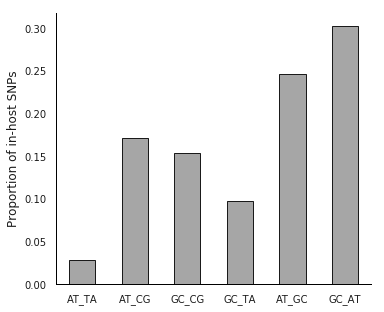

In [30]:
#####################  set plot parameters  ####################
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=3
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['axes.grid']=True
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 12})
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'

#####################  Bar Plot of SNP types  ####################
color = '0.65'

fig , ax = plt.subplots()

ax.bar([1] , [AT_TA/num_SNPs] ,   color = color , width = 0.5 , edgecolor ='k' , linewidth = 1.0)
ax.bar([2] , [AT_CG/num_SNPs] ,   color = color , width = 0.5 , edgecolor ='k' , linewidth = 1.0)
ax.bar([3] , [GC_CG/num_SNPs] ,   color = color , width = 0.5 , edgecolor ='k' , linewidth = 1.0)
ax.bar([4] , [GC_TA/num_SNPs] ,   color = color , width = 0.5 , edgecolor ='k' , linewidth = 1.0)
ax.bar([5] , [AT_GC/num_SNPs] ,   color = color , width = 0.5 , edgecolor ='k' , linewidth = 1.0)
ax.bar([6] , [GC_AT/num_SNPs] ,   color = color , width = 0.5 , edgecolor ='k' , linewidth = 1.0)


ax.yaxis.set_major_formatter(plt.ScalarFormatter())
ax.tick_params(axis='y', which='major', labelsize=10 )

ax.set_xlim([0.5 , 6.5])
ax.set_ylabel('Proportion of in-host SNPs' , color = 'k' , fontsize = 12)
#ax.set_xlabel('SNP type' , fontsize = 12 , color = 'k')

#x-axis
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels([], rotation='horizontal', fontsize = 10)
x_labels = ['AT_TA' , 'AT_CG' , 'GC_CG' , 'GC_TA' , 'AT_GC' , 'GC_AT']
ax.set_xticklabels(x_labels, rotation='horizontal', fontsize = 10)


ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.tick_params(labelcolor = 'k')

fig = plt.gcf()
fig.set_size_inches(5.5, 4.5)
fig.tight_layout()

#output for Adobe Illustrator
file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/longitudinal_SNP_analysis/spectrum_of_mutations.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()
##################################################################

### Compare $\Delta AF$ between Syn, NSyn & Intergenic SNPs

In [31]:
SNP_variants_within_patients.head()

,population,patient_id,ref_position,ref_allele,alt_allele,gene_id,genomic_coord,gene_category,gene_symbol,alt_AF_diff,SNP_type,AA_change,allele_1,allele_2,alt_AF_1,alt_AF_2,altAF2_minus_altAF1
0,CASALI,P251,761139,C,G,Rv0667,1333,Antibiotic Resistance,rpoB,1.0,N,H445D,C,G,0.0,1.0,1.0
1,CASALI,P251,861378,T,G,Rv0768,467,Non-Essential,aldA,1.0,N,I156S,T,G,0.0,1.0,1.0
2,BRYANT,2020E,1253207,A,G,Rv1129c,1328,Non-Essential,NaN,1.0,N,I443T,A,G,0.0,1.0,1.0
3,BRYANT,2020E,2075138,T,A,Rv1830,298,Non-Essential,NaN,1.0,N,S100T,T,A,0.0,1.0,1.0
4,BRYANT,2020E,2694727,A,G,Rv2397c,238,Essential,cysA1,1.0,N,F80L,A,G,0.0,1.0,1.0


In [32]:
np.shape(SNP_variants_within_patients)

(175, 17)

### *Function* for Boxplots

In [33]:
from pylab import plot, show, savefig, xlim, figure, hold, ylim, legend, boxplot, setp, axes

linewidth_for_box = 3.0

# function for setting the colors of the box plots pairs
def setBoxColors(bp , color):
    setp(bp['boxes'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['caps'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][0], color=color , linewidth = linewidth_for_box)
    setp(bp['whiskers'][1], color=color , linewidth = linewidth_for_box)
    setp(bp['fliers'][0], color=color , alpha = 0.65)
    setp(bp['medians'][0], color=color , linewidth = 3.0)
    bp['fliers'][0].set_markerfacecolor(color)
    bp['fliers'][0].set_markeredgewidth(0.5)
    bp['fliers'][0].set_markersize(6.0)
    bp['fliers'][0].set_markeredgecolor('white')
    
def values_to_variant_types(values):
    SNP_vals = values.alt_AF_diff
    return [SNP_vals]

def color_bar(bar , color):
    bar.set_color(color)
    bar.set_edgecolor('black')
    bar.set_linewidth(1.0)

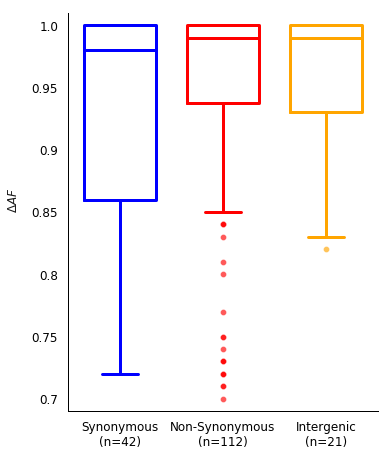

In [34]:
fig = plt.figure(1, figsize=(5.25, 6.5))
ax1 = axes()

box_width = 0.7
ind = [1,2,3]

### Example in case we want to show means later ###
##Syn_values = SNP_variants_within_patients[SNP_variants_within_patients.SNP_type == 'S']
##meanlineprops = dict(linestyle='--' , color = 'b' , linewidth = linewidth_for_box)
##bp = ax1.boxplot(values_to_variant_types(Syn_values) , positions = [ind[0]], widths = box_width , meanprops = meanlineprops, meanline = True, showmeans = True)
##setBoxColors(bp , 'b')

#Synonymous Mutations
Syn_values = SNP_variants_within_patients[SNP_variants_within_patients.SNP_type == 'S']
bp = ax1.boxplot(values_to_variant_types(Syn_values) , positions = [ind[0]], widths = box_width)
setBoxColors(bp , 'blue')

#Non-Synonymous Mutations
NSyn_values = SNP_variants_within_patients[SNP_variants_within_patients.SNP_type == 'N']
bp = ax1.boxplot(values_to_variant_types(NSyn_values) , positions = [ind[1]], widths = box_width)
setBoxColors(bp , 'red')

#Intergenic Mutations
Int_values = SNP_variants_within_patients[SNP_variants_within_patients.SNP_type == 'I']
bp = ax1.boxplot(values_to_variant_types(Int_values) , positions = [ind[2]], widths = box_width)
setBoxColors(bp , 'orange')

#y-labels
ax1.set_ylim([0.69 , 1.01])
ax1.set_yticks(np.arange(0.70 , 1.01 , .05))
y_labels = np.round( np.arange(0.70 , 1.00 , .05) , 2)
ax1.set_yticklabels(y_labels, rotation='horizontal', fontsize = 12)  
ax1.tick_params(axis='y', which='major', labelsize=12, pad = 4)

#x-labels
ax1.set_xlim([0.5 , 3.5])
ax1.set_xticks(ind)
x_labels = ['Synonymous\n(n=' + str(len(Syn_values)) + ')', 'Non-Synonymous\n(n=' + str(len(NSyn_values)) + ')', 'Intergenic\n(n=' + str(len(Int_values)) + ')']
ax1.set_xticklabels(x_labels, rotation='horizontal', fontsize = 12)  

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

#label y-axis
fig.text(-0.013, 0.56, '$\Delta AF$' ,  ha='center', va='center', rotation=90, fontsize = 12 , color = 'k')

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='on') # labels along the bottom edge are off

plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off',         # ticks along the top edge are off
    labelleft='on') # labels along the bottom edge are off


fig = plt.gcf()
fig.tight_layout()

#output for Adobe Illustrator
file_name = '/n/data1/hms/dbmi/farhat/Roger/inhost_TB_dynamics_project/figures/longitudinal_SNP_analysis/Syn_vs_NSyn_vs_change_in_AF.pdf'
plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()